In [3]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np

import time
import matplotlib.pyplot as plt
import re
import pickle
from collections import deque
import random
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from gurobipy import GRB, Model

import warnings 
warnings.filterwarnings('ignore')
import os
import glob

In [4]:
EPOCHS = 40
BATCH_SIZE = 8
LOOKFORWARD = 5
WINDOW = 15

In [5]:
def load_files(folder):
    path = r"{}/*.csv".format(folder)
    df_list = {}
    for fname in glob.glob(path):
        df=pd.read_csv(fname)
        stock_name = re.findall(r'SH\d{6}', fname)[0]
        df_list[stock_name] = df
    return df_list

In [6]:
engineered_features_list = load_files('engineered features')
raw_list = load_files('raw data')

In [7]:
def MA_std(df, col='Close', ranges=[5, 7, 15], std=True, custom=''):
    for i in ranges:
        df[f'{custom}MA_{i}lag'] = df[col].rolling(window=i).mean().shift(1)
        if std:
            df[f'{custom}MA_{i}_lag_std'] = df[col].rolling(window=i).std().shift(1)

def BB(df, std=2, ranges=[5, 7, 15]):
    for i in ranges:
        df[f'MA_{i}_BB_lag_high'] = df[f'MA_{i}lag'] + std * df[f'MA_{i}_lag_std']
        df[f'MA_{i}_BB_lag_low'] = df[f'MA_{i}lag'] - std * df[f'MA_{i}_lag_std']

In [8]:
def get_response(df, days=5, categorical=True):
    if categorical:
        target = ((df['Close'].shift(-(days - 1)) - df['Close'] - 0.00065 * df['Close'] - 0.00065 * df['Close'].shift(-(days - 1))) > 0).astype(float)
        return target
    return (df['Close'].shift(-(days - 1)) - df['Close']) / df['Close'] * 100

In [9]:
def resample(sequential_data):
    buys = []
    sells = []
    for seq, target in sequential_data:
        if target == 0:
            sells.append([seq, target])
        else:
            buys.append([seq, target])
    if len(buys) > len(sells):
        sells = [[sells[i][0], sells[i][1]] for i in np.random.randint(len(sells), size=len(buys))]
    elif len(buys) < len(sells):
        buys = [[buys[i][0], buys[i][1]] for i in np.random.randint(len(buys), size=len(sells))]
    sequential_data = list(buys) + list(sells)
    random.shuffle(sequential_data)
    return sequential_data

In [10]:
def split_data(sequential_data):
    x, y = [], []
    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    return x, y

In [11]:
def preprocessing(df, days, window, scaler=None, resample_data=True):
    #normalize data
    dataframe = df.copy()
    dataframe.set_index('Time', inplace=True)
    target = dataframe[f'{days}day_Up']
    dataframe.drop(f'{days}day_Up', axis = 1, inplace = True)
    dataframe = dataframe.replace(to_replace=0, method='ffill')
    for col in dataframe.columns:
        dataframe[col] = dataframe[col].pct_change()
    
    #scaling
    newscale = False
    if scaler is None:
        newscale = True
        scaler = MinMaxScaler()
    columns = dataframe.columns 
    dataframe = dataframe.replace([np.inf, -np.inf, 0], method='ffill')
    dataframe = dataframe.dropna()
    Time = dataframe.index.values
    if newscale:
        scaled_df = scaler.fit(dataframe)
    scaled_df = scaler.transform(dataframe)
    scaled_df = pd.DataFrame(scaled_df, columns = columns, index = Time)
    scaled_df = scaled_df.merge(target, how='left', left_index=True, right_index=True)
    
    #building sequences
    sequential_data = []
    prev_days = deque(maxlen = window)
    for i in scaled_df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == window:
            sequential_data.append([np.array(prev_days), i[-1]])
    if resample_data:
        sequential_data = resample(sequential_data)
    
    x, y = split_data(sequential_data)
    return np.array(x), y, scaler

In [12]:
def OOT_spilt(df):
    stock_df = df.copy()
    stock_df.set_index('Time', inplace=True)
    stock_df_intime = stock_df.loc[:'Day504',:].reset_index()
    stock_df_OOT = stock_df.loc['Day490':,:].reset_index()
    return stock_df_intime, stock_df_OOT

In [13]:
def get_dataframe(df1, df2, days, window):
    MA_std(df2)
    BB(df2)
    MA_std(df2, col='Volume', std=False, custom='V')
    stock_df = df2.merge(df1, how='inner', left_on='Time', right_on='Unnamed: 0')
    stock_df.drop(['Unnamed: 0','MA5lag','MA15lag'], axis=1, inplace=True)
    stock_df[f'{days}day_Up'] = get_response(df2,days=days,categorical=True)
    
    intime_df, oot_df = OOT_spilt(stock_df)
    
    #normalizing and scaling
    X_train, y_train, scaler = preprocessing(intime_df, days, window)
    X_test, y_test, _ = preprocessing(oot_df, days, window, scaler, resample_data=False)
    return X_train, y_train, X_test, y_test

In [14]:
def stocks_predictions(days=5, window=15, categorical=True, dense_size=32):
    models = {}
    num_stock = 0
    for stock in engineered_features_list:
        if num_stock % 10 == 0:
            print(f'Working on stock {num_stock}')

        name = f'{window}-WINDOW-{days}-PERIOD-{stock}'

        X_train, y_train, X_test, y_test = get_dataframe(engineered_features_list[stock], raw_list[stock], days, window)

        y_train = np.array(y_train)
        y_test = np.array(y_test)

        models[name] = LSTM_stock_model(X_train.shape[1:], dense_size)
        opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

        models[name].compile(loss='binary_crossentropy',
                            optimizer=opt,
                            metrics=['accuracy','AUC'])
        tensorboard = TensorBoard(log_dir=os.path.join('logs',name+'_'+str(dense_size)+'_'+str(days)+'_'+str(window)))
        checkpoint_path = f"models/training_{name}_{dense_size}_{days}_{window}/cp.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        os.mkdir(checkpoint_dir)

        # Create a callback that saves the model's weights
        cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy',
                                      save_weights_only=True,verbose=0, 
                                      save_best_only=True, mode='max')
        
        history = models[name].fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=0,
            validation_data=(X_test,y_test),
            callbacks=[tensorboard, cp_callback])
        num_stock += 1
    
        
    return models

In [16]:
def LSTM_stock_model(X_shape, dense_size):
    return tf.keras.models.Sequential([
    LSTM(128, input_shape=(X_shape), dropout=0.1, recurrent_dropout=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(dense_size, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
  ])

In [17]:
def evaluate(stocks_model, days=5, window=15):
    predictions = {}
    f1_scores = {}
    num_stock = 0
    for stock, model in stocks_model.items():
        if num_stock % 10 == 0:
            print(f'Working on stock {num_stock}')
        name = stock
        stock = re.findall(r'-(SH\d{6})', stock)[0]
        _, _, X_test, y_test = get_dataframe(engineered_features_list[stock], raw_list[stock], days, window)
        predictions[stock] = stocks_model[name].predict_proba(X_test)
        ypred = predictions[stock] > 0.5
        y_test = np.array(y_test).reshape(-1,1)
        f1_scores[stock] = f1_score(y_test, ypred)
        #add other metrics here AUC? Recall?
        num_stock += 1
    return predictions, f1_scores #,AUC, Recall

In [18]:
def dicts_to_pickle(dictionary, name):
    pickle.dump( dictionary, open( f"{name}.p", "wb" ) )
    return

In [19]:
def ml_stocks_predictions(model, days=5, window=15, categorical=True):
    models = {}
    num_stock = 0
    for stock in engineered_features_list:
        if num_stock % 10 == 0:
            print(f'Working on stock {num_stock}')

        name = f'{window}-WINDOW-{days}-PERIOD-{stock}'

        X_train, y_train, X_test, y_test = get_dataframe(engineered_features_list[stock], raw_list[stock], days, window)
        X_train = X_train.reshape(X_train.shape[0],-1)
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        models[name] = model#RandomForestClassifier()#svm.SVC(probability=True)#LogisticRegression()#XGBClassifier()
        models[name].fit(X_train, y_train)
        num_stock += 1
    return models

In [20]:
def ml_evaluate(stocks_model, days=5, window=15):
    predictions = {}
    f1_scores = {}
    num_stock = 0
    for stock, model in stocks_model.items():
        if num_stock % 10 == 0:
            print(f'Working on stock {num_stock}')
        name = stock
        stock = re.findall(r'-(SH\d{6})', stock)[0]
        _, _, X_test, y_test = get_dataframe(engineered_features_list[stock], raw_list[stock], days, window)
        X_test = X_test.reshape(X_test.shape[0],-1)
        predictions[stock] = stocks_model[name].predict_proba(X_test)[:,1]
        ypred = predictions[stock] > 0.5
        y_test = np.array(y_test).reshape(-1,1)
        f1_scores[stock] = f1_score(y_test, ypred)
        #add other metrics here AUC? Recall?
        num_stock += 1
    return predictions, f1_scores #,AUC, Recall

In [870]:
stocks_model = ml_stocks_predictions(model=RandomForestClassifier(), days=LOOKFORWARD, window=WINDOW)

Working on stock 0
Working on stock 10
Working on stock 20
Working on stock 30
Working on stock 40


In [871]:
predictions, f1_scores = ml_evaluate(stocks_model, days=LOOKFORWARD, window=WINDOW)

Working on stock 0
Working on stock 10
Working on stock 20
Working on stock 30
Working on stock 40


In [872]:
np.array(list(f1_scores.values())).mean()

0.6249934642932756

In [ ]:
stocks_model = stocks_predictions(days=LOOKFORWARD, window=WINDOW, categorical=True, dense_size=32)

In [259]:
predictions, f1_scores = evaluate(stocks_model, days=LOOKFORWARD, window=WINDOW)

Working on stock 0
Working on stock 10
Working on stock 20
Working on stock 30
Working on stock 40


In [260]:
np.array(list(f1_scores.values())).mean()

0.9431828925448399

In [ ]:
dicts = [predictions, f1_scores]
names = ['predictions', 'f1_scores']
for i in range(len(dicts)):
    dicts_to_pickle(dicts[i], names[i])

---

# optimization

In [56]:
def pickle_to_dicts(names):
    return pickle.load( open( f"{names}.p", "rb" ) )

In [57]:
predictions = pickle_to_dicts('predictions')
f1_scores = pickle_to_dicts('f1_scores')

In [58]:
for key in predictions:
    scaler = MinMaxScaler(feature_range = (-1.5, 1))
    predictions[key] = scaler.fit_transform(predictions[key].reshape(-1,1))

In [59]:
def get_labels(raw_list):
    stock_labels = {}
    for stock in raw_list:
        stock_df = raw_list[stock].copy()
        stock_df['target'] = get_response(stock_df)
        stock_df['rolling std'] = stock_df['Close'].rolling(90).std()
        stock_df = stock_df.set_index('Time').loc['Day505':,:]
        stock_df = stock_df[['Close', 'target', 'rolling std']]
        stock_labels[stock] = stock_df.copy()
    return stock_labels

In [60]:
stock_labels = get_labels(raw_list)

In [65]:
naive_trade_df, naive_holdings, naive_leftover = naive_trade(stock_labels, 0.2, 1)
naive_sharpe_ratio, naive_asset_df = performance(naive_trade_df, naive_holdings, naive_leftover, stock_labels)
naive_sharpe_ratio

0.7483857137966085

In [66]:
(naive_asset_df.pnl > 0).sum()

122

In [67]:
naive_asset_df

,asset,pnl
Day505,999870.09,nan
Day506,1000690.68,0.00
Day507,1000560.76,-0.00
Day508,995513.73,-0.01
Day509,989334.33,-0.01
...,...,...
Day752,1098881.81,-0.00
Day753,1098881.81,0.00
Day754,1098881.81,0.00
Day755,1098881.81,0.00


In [26]:
def naive(S, day, available_fund, diversify, risk_tolerance):
    sd_dict = {s:stock_labels[s].loc[f'Day{day}', 'rolling std'] for s in S if stock_labels[s].loc[f'Day{day}', 'rolling std'] <= risk_tolerance}
    full_share = 1
    x = {s:0 for s in S}
    prediction = {s:predictions[s][day - 505][0] for s in sd_dict.keys()}
    best_predict = -float('inf')
    best_stock = None
    stocks_bought = []
    while True:
        for stock in prediction:
            if stock in stocks_bought or prediction[stock] <= best_predict:
                continue
            best_predict = prediction[stock]
            best_stock = stock
        if full_share - diversify <= 0 or available_fund <= 1000:
            shares = available_fund * diversify // stock_labels[best_stock].loc[f'Day{day}', 'Close']
            x[best_stock] = shares
            return x
        full_share -= diversify
        shares = available_fund * diversify // stock_labels[best_stock].loc[f'Day{day}', 'Close']
        available_fund *= full_share
        x[best_stock] = shares
        stocks_bought.append(best_stock)
        best_predict = -float('inf')
        if full_share <= 0:
            return x

In [27]:
def naive_trade(stock_labels, risk_tolerance, diversify, fund=1000000, days=[d for d in range(505, 752)]):
    S = list(stock_labels.keys())
    holdings = deque()
    leftover, selling = 0, 0
    total_asset,stocknums = [], []
    list_of_stocks = {}
    for day in days:
        if len(holdings) > 4:
            list_of_stocks = holdings.popleft()
            selling = sum(list_of_stocks[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S)*0.99935
        if day < 510: 
            available_fund = fund / 5 + leftover
        else:
            available_fund = selling + leftover
        x = naive(S, day, available_fund*0.99935, diversify, risk_tolerance)
        holdings.append(x)
        
        leftover = available_fund - sum(x[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S) * 1.00065
        
        holding_total = 0
        for holding in holdings:
            holding_total += sum(holding[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S)
        if len(holdings) < 5:
            total_asset.append(round(leftover + fund*(5-(len(holdings)))/5 + holding_total, 2))
        else:
            total_asset.append(round(leftover + holding_total, 2))

        stocknums.append([int(holding[s]) if holding[s] else 0 for s in S])

    stock_buy_df = pd.DataFrame(stocknums, index=['Day'+str(d) for d in range(505, 752)], columns=S)
    stock_buy_df['asset'] = total_asset
    return stock_buy_df, holdings, leftover

**Data:**
- $S$: the set of stocks.
- $D$: the set of trading days.
- $f1_s$: the confidence score of stock $s$ model.
- $p_{sd}$: the up predictor for stock $s$ on day $d$.
- $c_{sd}$: the close price for stock $s$ on day $d$.
- $v_{sd}$: the 90 day rolling standard deviation for stock $s$ on day $d$.
- $a_{d}$: the available fund on day d.

**Tuning Variables:**
- $Q$: the maximum percentage of fund allocated on each stock.
- $R$: the risk tolerance binding parameter which the sum of (each stock value in hand * standard deviation of the stock) cannot exceed.
- $J$: the importance of model confidence.

**Decision Variables:**
- $x_{sd}$: how many to buy for each stock $s \in S$ on trading day $d \in D$.(Continuous)

**Objective and Constraints:**
$$\begin{aligned}
\text{Maximize:} && \sum_{s \in S} (Jf1_s+p_{sd})c_{sd}x_{sd} && \text{for each trading day $d \in D$.}\\
\text{subject to:} \\
\text{(Risk tolerance)} && \sum_{s \in S} x_{sd}c_{sd}v_{sd} & \le R \\
\text{(Available Fund)} && \sum_{s \in S} x_{sd}c_{sd} & \le a_d \\
\text{(Diversity)} && c_{sd}x_{sd} & \le Qa_{d} && \text{for each stock $s \in S$.} \\
\text{(Non-negativity)} && x_{sd} & \ge 0 && \text{for each stock $s \in S$ for each day $d \in D$.}
\end{aligned}$$


In [28]:
def optimize(S, day, mod, available_fund, diversify, risk_tolerance):
    x = mod.addVars(S, vtype=GRB.INTEGER)
    mod.setObjective(sum((0.5*f1_scores[s] + predictions[s][day - 505][0]) * x[s] * stock_labels[s].loc[f'Day{day}', 'Close'] for s in S), sense=GRB.MAXIMIZE)
    mod.addConstr(sum(x[s] * stock_labels[s].loc[f'Day{day}', 'Close'] * stock_labels[s].loc[f'Day{day}', 'rolling std'] for s in S) <= risk_tolerance)
    for s in S:
        mod.addConstr(x[s] * stock_labels[s].loc[f'Day{day}', 'Close'] <= available_fund * diversify)
    mod.addConstr(sum(x[s] * stock_labels[s].loc[f'Day{day}', 'Close'] for s in S) <= available_fund)
    mod.setParam('OutputFlag',False)
    mod.optimize()
    return mod, x

In [29]:
def trade(stock_labels, risk_tolerance, diversify, fund=1000000, days=[d for d in range(505, 752)]):
    S = list(stock_labels.keys())
    holdings = deque()
    leftover, selling = 0, 0
    total_asset,stocknums = [], []
    mod = Model()
    mod.setParam('OutputFlag',False)
    for day in days:
        if len(holdings) > 4:
            list_of_stocks = holdings.popleft()
            selling = sum(list_of_stocks[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S)*0.99935
        if day < 510: 
            available_fund = fund / 5 + leftover
        else:
            available_fund = selling + leftover
        S = list(stock_labels.keys())
        mod.reset()
        model, x = optimize(S, day, mod, available_fund*0.99935, diversify, risk_tolerance)
        number_of_stocks = {s:x[s].x for s in S}
        holdings.append(number_of_stocks)
        
        leftover = available_fund - sum(x[s].x*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S) * 1.00065

        holding_total = 0
        for holding in holdings:
            holding_total += sum(holding[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S)
        if len(holdings) < 5:
            total_asset.append(leftover + fund*(5-(len(holdings)))/5 + holding_total)
        else:
            total_asset.append(leftover + holding_total)

        stocknums.append([int(holding[s]) if holding[s] else 0 for s in S])

    stock_buy_df = pd.DataFrame(stocknums, index=['Day'+str(d) for d in range(505, 752)], columns=S)
    stock_buy_df['asset'] = total_asset
    return stock_buy_df, holdings, leftover

In [30]:
def performance(stock_buy_df, holdings, leftover, stock_labels, day=752):
    total = 0
    S = list(stock_labels.keys())
    index, stocknums = [], []
    for holding in holdings:
        total += sum(holding[s]*stock_labels[s].loc[f'Day{day}', 'Close'] for s in S)*0.99935
        index.append(f'Day{int(day)}')
        day += 1
    finaldays = pd.Series([total + leftover]*5, index=index)
    asset_df = pd.DataFrame(stock_buy_df['asset'].append(finaldays),columns = ['asset'])
    asset_df['pnl'] = asset_df.asset / asset_df.asset.shift(1) - 1
    pnl_mean = asset_df['pnl'].mean()
    pnl_std = asset_df['pnl'].std()
    Sharpe_ratio = np.sqrt(252) * pnl_mean / pnl_std
    return Sharpe_ratio, asset_df

In [31]:
aggressive_trade_df, aggressive_holdings, aggressive_leftover = trade(stock_labels, 50000, 1)
aggressive_sharpe_ratio, aggressive_asset_df = performance(aggressive_trade_df, aggressive_holdings, aggressive_leftover, stock_labels)
aggressive_sharpe_ratio

Using license file C:\Users\andre\gurobi.lic
Academic license - for non-commercial use only


1.6563544844800486

In [32]:
aggressive_asset_df

,asset,pnl
Day505,999870.08,nan
Day506,1000690.68,0.00
Day507,998837.74,-0.00
Day508,995861.45,-0.00
Day509,979945.03,-0.02
...,...,...
Day752,1268013.10,0.04
Day753,1268013.10,0.00
Day754,1268013.10,0.00
Day755,1268013.10,0.00


In [33]:
(aggressive_asset_df['pnl'] > 0).sum()

121

---

In [34]:
conservative_trade_df, conservative_holdings, conservative_leftover = trade(stock_labels, 30000, 0.85)
conservative_sharpe_ratio, conservative_asset_df = performance(conservative_trade_df, conservative_holdings, conservative_leftover, stock_labels)
conservative_sharpe_ratio

1.8005250858012825

In [35]:
conservative_asset_df

,asset,pnl
Day505,999870.08,nan
Day506,1000859.30,0.00
Day507,999305.24,-0.00
Day508,996323.27,-0.00
Day509,988577.70,-0.01
...,...,...
Day752,1253613.36,0.05
Day753,1253613.36,0.00
Day754,1253613.36,0.00
Day755,1253613.36,0.00


In [36]:
(conservative_asset_df.pnl > 0).sum()

127

Text(0.5, 1.0, 'Trading Strategies')

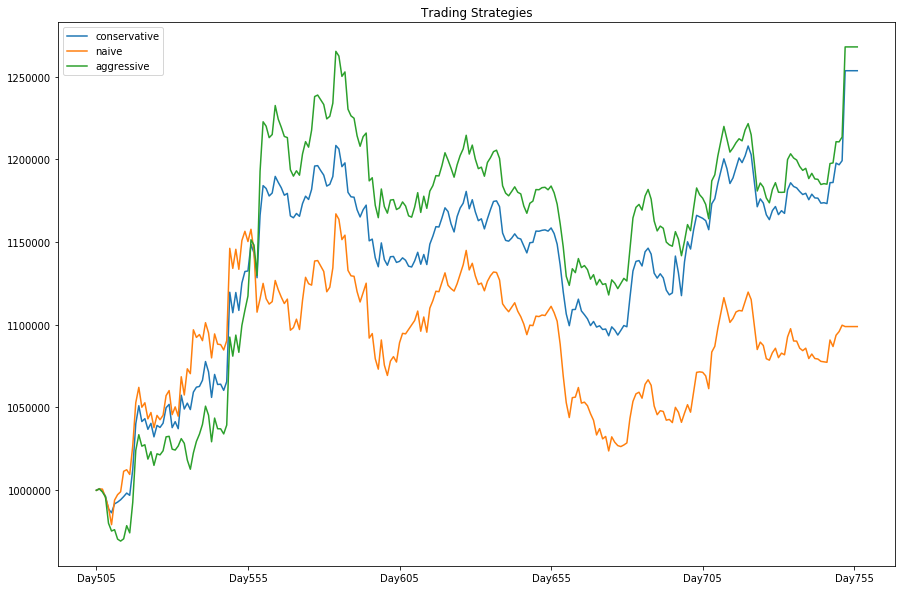

In [68]:
plt.figure(figsize=(15,10))
conservative_asset_df.asset.plot(label = 'conservative')
naive_asset_df.asset.plot(label = 'naive')
aggressive_asset_df.asset.plot(label = 'aggressive')
plt.legend()
plt.title("Trading Strategies")